In [1]:
'''
Dataset available through the UCI Machine Learning Repository.
Download information and complete attribute descriptions can be found at the following link.
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In this notebook, I use 14 different biomarkers to predict the likelihood that an individual has heart disease 
by employing variable selection and logistic regression.
'''

'\nDataset available through the UCI Machine Learning Repository.\nDownload information and complete attribute descriptions can be found at the following link.\nhttps://archive.ics.uci.edu/ml/datasets/Heart+Disease\n\nIn this notebook, I use 14 different biomarkers to predict the likelihood that an individual has heart disease \nby employing variable selection and logistic regression.\n'

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from pandas.plotting import scatter_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
os.chdir(r'C:\Users\alo19\Documents\Heart Disease')
pd.set_option('display.precision', 3)
warnings.filterwarnings("ignore")

df = pd.read_csv('heart.csv', header=0)
df.dropna()

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

In [5]:
print(list(df.columns))

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000
mean,54.366,0.683,0.967,131.624,246.264,0.149,0.528,149.647,0.327,1.040,1.399,0.729,2.314,0.545
std,9.082,0.466,1.032,17.538,51.831,0.356,0.526,22.905,0.470,1.161,0.616,1.023,0.612,0.499
min,29.000,0.000,0.000,94.000,126.000,0.000,0.000,71.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,47.500,0.000,0.000,120.000,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,2.000,0.000
50%,55.000,1.000,1.000,130.000,240.000,0.000,1.000,153.000,0.000,0.800,1.000,0.000,2.000,1.000
75%,61.000,1.000,2.000,140.000,274.500,0.000,1.000,166.000,1.000,1.600,2.000,1.000,3.000,1.000
max,77.000,1.000,3.000,200.000,564.000,1.000,2.000,202.000,1.000,6.200,2.000,4.000,3.000,1.000


In [7]:
df.groupby('sex').mean()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
sex,,,,,,,,,,,,,
0,55.677,1.042,133.083,261.302,0.125,0.573,151.125,0.229,0.876,1.427,0.552,2.125,0.750
1,53.758,0.932,130.947,239.290,0.159,0.507,148.961,0.372,1.115,1.386,0.812,2.401,0.449


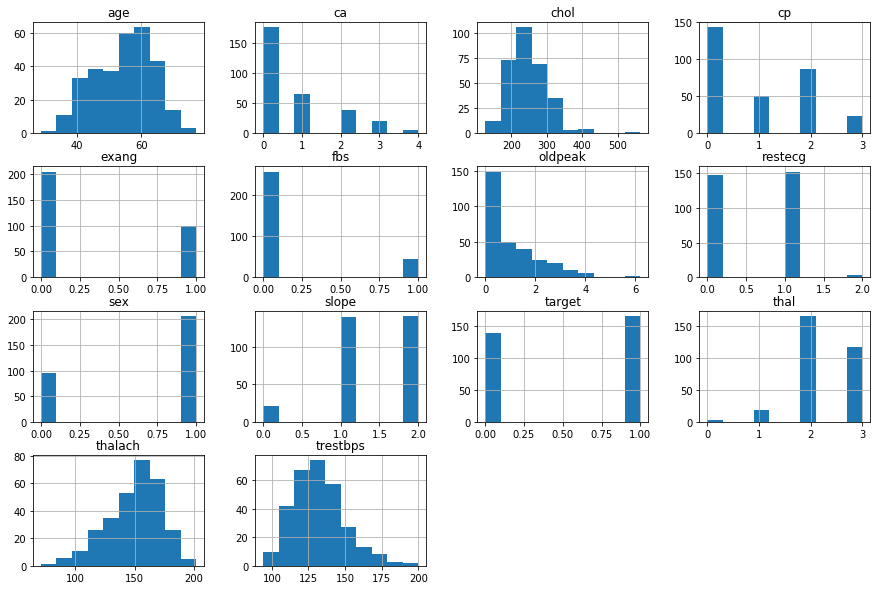

In [8]:
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure(figsize=(4, 3))
df.hist()
plt.show()

In [9]:
df['has_hd'] = df['cp'] > 0 # Create binary indicator for chest pain
features_list = ['age','sex','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
X, y = df.loc[:, features_list], df[['has_hd']]
X.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,145,233,1,0,150,0,2.3,0,0,1
1,37,1,130,250,0,1,187,0,3.5,0,0,2
2,41,0,130,204,0,0,172,0,1.4,2,0,2
3,56,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,120,354,0,1,163,1,0.6,2,0,2


In [10]:
y.head()

,has_hd
0,True
1,True
2,True
3,True
4,False


In [11]:
# The target variable is somewhat imbalanced
y.groupby(['has_hd']).size()

has_hd
False    143
True     160
dtype: int64

In [12]:
# We can correct this through SMOTE oversampling on the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_train = y_train.values.ravel()
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [14]:
# The training data is now balanced
np.unique(y_train, return_counts=True)

(array([False,  True], dtype=bool), array([110, 110]))

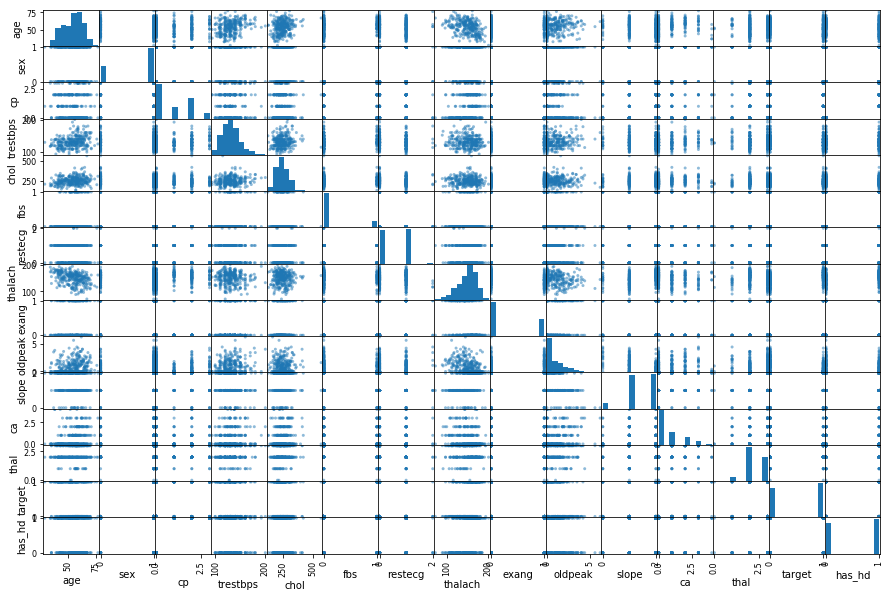

In [15]:
# Checking for multicollinearity between features
scatter_matrix(df)
plt.show()

In [16]:
# The scatterplot matrix shows some correlation between features
# We'll look at the VIF to determine any correlation in >2 dimensions
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,38.922,age
1,3.521,sex
2,58.296,trestbps
3,26.176,chol
4,1.252,fbs
5,2.057,restecg
6,41.298,thalach
7,1.825,exang
8,3.063,oldpeak
9,10.069,slope


In [17]:
# Several variables have VIF values >5 so we'll consider PCA to perform dimension reduction on normalized data
data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns) 
pca = PCA(n_components=7)
pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7'])
pca_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,has_hd
PC-1,0.207,0.108,-0.334,0.107,0.079,0.025,-0.096,-0.333,0.327,0.318,-0.275,0.229,0.201,-0.409,-0.390
PC-2,0.429,-0.196,0.390,0.442,0.238,0.325,-0.187,-0.077,-0.147,0.189,-0.192,0.152,-0.073,0.035,0.322
PC-3,0.214,-0.547,-0.341,0.037,0.490,-0.129,-0.111,-0.003,0.004,-0.270,0.264,-0.040,-0.188,0.126,-0.271
PC-4,0.006,-0.383,0.052,-0.120,-0.158,-0.303,0.284,-0.293,0.046,0.303,-0.461,-0.357,-0.308,0.154,0.030
PC-5,-0.203,0.003,0.135,0.084,0.454,-0.441,-0.199,0.264,0.024,0.220,-0.134,-0.298,0.504,-0.044,0.112
PC-6,0.272,-0.083,0.082,-0.056,0.072,-0.279,0.689,-0.086,-0.185,0.014,0.196,0.368,0.347,-0.056,0.108
PC-7,-0.221,-0.148,-0.134,0.501,-0.016,0.425,0.486,0.236,0.241,0.019,0.007,-0.286,0.166,0.053,-0.129


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [20]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[27 14]
 [10 40]]


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.66      0.69        41
        True       0.74      0.80      0.77        50

   micro avg       0.74      0.74      0.74        91
   macro avg       0.74      0.73      0.73        91
weighted avg       0.74      0.74      0.73        91



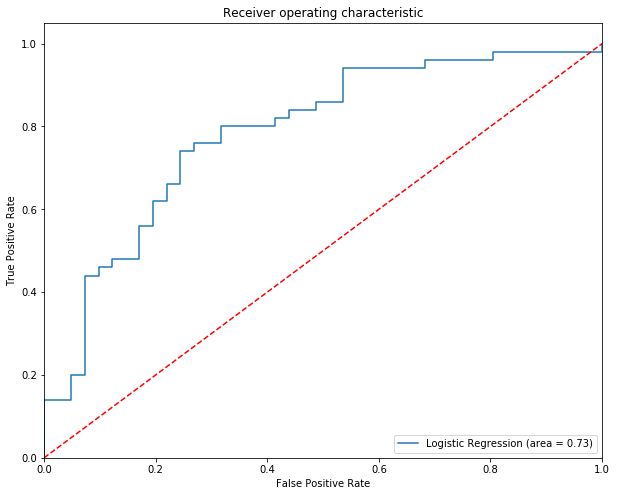

In [22]:
# Create ROC Curve
plt.rcParams["figure.figsize"] = (10,8)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()